# Steady-state heat diffusion in 1D cylindrical mesh

version 230804, MW

This example will evaluate the analytic solution for a simple steady-state heat transfer problem, and use PyFVTool to solve the same problem by the finite-volume method.

In [1]:
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt

In [2]:
# enable access to parent directory in order to access pyfvtool module (without pip installation)
from sys import path
path.append('..')

In [3]:
# explicity import all required routines from pyfvtool
from pyfvtool import createMeshCylindrical1D, createBC
from pyfvtool import createCellVariable
from pyfvtool import transientTerm, diffusionTerm
from pyfvtool import harmonicMean, boundaryConditionTerm
from pyfvtool import constantSourceTerm
from pyfvtool import solvePDE

In [4]:
# add a utility function to extract 1D profile
# this may later become a method of CellVariable
def get_CellVariable_profile1D(cv):
    x = np.hstack([cv.domain.facecenters.x[0],
                   cv.domain.cellcenters.x,
                   cv.domain.facecenters.x[-1]])
    phi = np.hstack([0.5*(cv.value[0]+cv.value[1]),
                     cv.value[1:-1],
                     0.5*(cv.value[-2]+cv.value[-1])])
    # The size of the ghost cell is always equal to the size of the 
    # first (or last) cell within the domain. The value at the
    # boundary can therefore be obtained by direct averaging with a
    # weight factor of 0.5.
    return (x, phi)

## Problem statement

The steady-state heat equation in 1D cylindrical geometry (total cylinder radius $R$), with an internal heat source (strength $S$) and Dirichlet (constant-value) outer boundary. This can model, for example the temperature (temperature $T$ relative to outer temperature) profile in a electrically resistive wire through which a current passes.

$$ 0 = k \nabla^2 T + S $$ 

which, under the circumstances mentioned above, should have solution

$$ T(r) = \frac{S}{4k} (R^2 - r^2) $$

*Do not forget that we are in cylindrical coordinates and that $\nabla^2$ has the corresponding form.*


## System parameters

It is possibly wise to not set all parameters to 1 or even integer values for testing purposes but rather use something else.

In [5]:
R = 2.1
k_val = 3.7 # heat transfer coefficient
S_val = 4.2 # source strength
T_outer = 0.0  # (outer) boundary temperature

## Finite-volume solution with PyFVTool

Define 1D cylindrical grid with radius $R$.

In [6]:
Nr = 50
Lr = R

In [7]:
mesh = createMeshCylindrical1D(Nr, Lr)

Create coefficients of diffusion and source terms in the form of `CellVariable`s.

In [8]:
k = createCellVariable(mesh, k_val) # heat transfer coefficient

In [9]:
S = createCellVariable(mesh, S_val)

Create boundary condition: outer wall will be kept at 0.0. (Dirichlet boundary condition).

*Always create a boundary condition instance, even when using the default no-flux boundaries. In this case, you can just create the BC without further tuning.*

In [10]:
bc = createBC(mesh)

In [11]:
# switch the right (=outer) boundary to Dirichlet: fixed temperature
bc.right.a[:] = 0.0
bc.right.b[:] = 1.0
bc.right.c[:] = T_outer

Set up matrix equation from the PDE terms.

In [12]:
# the diffusion term requires the face values
k_face = harmonicMean(k)
Mdiff = diffusionTerm(k_face)

In [13]:
Mbc, RHSbc = boundaryConditionTerm(bc)

In [14]:
RHSsrc = constantSourceTerm(S)

In [15]:
M = -Mdiff + Mbc
RHS = RHSsrc + RHSbc

Go solve.

In [16]:
T = solvePDE(mesh, M, RHS)

Retrieve solution temperature profile from solution `CellVariable`.

In [17]:
rnum, Tnum = get_CellVariable_profile1D(T)

## Comparison with the analytic solution

In [18]:
r_an = np.linspace(0, R)
T_an = (S_val/(4*k_val))*(R**2 - r_an**2)

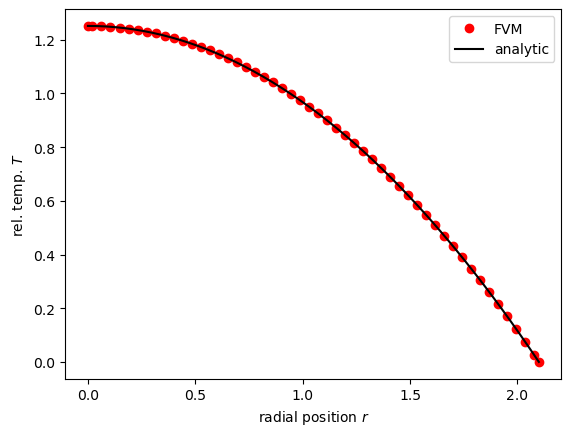

In [19]:
plt.plot(rnum, Tnum, 'ro', label='FVM')
plt.plot(r_an, T_an, 'k', label='analytic')
plt.ylabel('rel. temp. $T$')
plt.xlabel('radial position $r$')
plt.legend()